<div style='font-size: 3em'>SentiLens - Uncover reviews' hidden emotion</div>

__Prepared by:__ Tina Vu</br>
__Date:__ 20231208</br>

Employing aspect-based sentiment analysis (ABSA) to extract valuable feature insights from e-commerce product reviews, thereby empowering consumers to make more informed purchasing decisions and enhancing their overall user experience on the platform.

Utilizing manually annotated reviews for aspect sentiment analysis to extract aspects and predict sentiments from reviews. This enables consumers to obtain a condensed overview of sentiments related to various product features, eliminating the need to delve into an extensive array of reviews. As a result, the decision-making process becomes more streamlined and user-friendly.

__Approach:__

ABSA

__Phase:__
1. Supervised ABSA (What, How)
2. Unsupervised ABSA
3. Add 'Why' into ABSA

<div style='font-size: 2em'>Phase 1 - Aspect Extration</div>

**Table of contents**<a id='toc0_'></a>    
- 1. [Import & prepare dataset](#toc1_)    
  - 1.1. [Import data](#toc1_1_)    
  - 1.2. [Preparing dataset for modelling](#toc1_2_)    
    - 1.2.1. [Unified BIO tagging encode](#toc1_2_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [328]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import re

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, opinion_lexicon

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('opinion_lexicon')

# Load positive and negative words from the opinion lexicon
POSITIVE_WORDS = set(opinion_lexicon.positive())
NEGATIVE_WORDS = set(opinion_lexicon.negative())
EN_STOP_WORDS = set(stopwords.words('english'))
CONTEXT_SWITCHING_WORDS = ['but', 'yet', 'however', 'nevertheless', 'still', 'nonetheless', 'although', 'though', 'even though', 'while']
# nltk.download()


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report


from sklearn_crfsuite import CRF
from sklearn.ensemble import RandomForestClassifier



[nltk_data] Downloading package punkt to /Users/tina.vu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/tina.vu/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


# 1. <a id='toc1_'></a>[Import & prepare dataset](#toc0_)

## 1.1. <a id='toc1_1_'></a>[Import data](#toc0_)

We will load laptop reviews dataset with aspect term & sentiment annotations.

The dataset comes in two parts:
- train: 3,048 records
- test: 800 records

Each record is a sentence with zero, one or multiple aspect terms. Each aspect term has the following features:
- start character index
- end character index
- sentiment/ polarity (positive or negative)

In [2]:
df_train = pd.read_json('data/laptop/train.json')
df_val = pd.read_json('data/laptop/validate.json') # This will only be used for the very last step to evaluate how well the model is, but is input now for validating the BIO tagging to ensure the function works properly
df_train.shape

(3048, 3)

In [3]:
df_train.head()

,id,text,aspects
0,2339,I charge it at night and skip taking the cord ...,"[{'term': 'cord', 'polarity': 'neutral', 'from..."
1,812,I bought a HP Pavilion DV4-1222nr laptop and h...,"[{'term': '', 'polarity': '', 'from': 0, 'to':..."
2,1316,The tech guy then said the service center does...,"[{'term': 'service center', 'polarity': 'negat..."
3,2328,I investigated netbooks and saw the Toshiba NB...,"[{'term': '', 'polarity': '', 'from': 0, 'to':..."
4,2193,The other day I had a presentation to do for a...,"[{'term': '', 'polarity': '', 'from': 0, 'to':..."


## 1.2. <a id='toc1_2_'></a>[Preparing dataset for modelling](#toc0_)

The task we are solving is Named Entity Recognition (NER) which is a sequential labeling task, a.k.a we would like to predict whether a token (word) in each sentence is part of an aspect term or not.

In order to prepare the data for NER task, we need to label our tokens. Here, I implemented a unified BIO tagging technique which combines aspect boundaries and aspect sentiment.

Word boundaries:
- B: indicates the 1st word in the aspect term
- I: indicates the subsequent word in the aspect term
- O: indicates words that are not part of any aspect term

Aspect sentiment:
- POS: positive
- NEU: neutral
- NEG: conflict

This BIO label technique is more effective in recognizing unigram and n-gram aspect terms comparing to a binary classification (whether a token is part of an aspect). By using a unified a approach, we can combine two tasks: aspect extraction and sentiment classification into one task.

In [4]:
# First, I will need to drop some duplicated data in our training dataset, as identified in the EDA process.
df_train.drop_duplicates(subset='text', inplace=True)

# We have removed 12 duplicated records in our training dataset
df_train.shape

(3036, 3)

### 1.2.1. <a id='toc1_2_1_'></a>[BIO tagging encode](#toc0_)

Here, I defined a function to encode our sentences' aspects using a unified BIO tagging technique (<a href='https://arxiv.org/pdf/1811.05082.pdf'>reference</a>) that combines aspect boundaries and aspect sentiment in a single label.

Word boundaries:
- B: indicates the 1st word in the aspect term
- I: indicates the subsequent word in the aspect term
- O: indicates words that are not part of any aspect term

Aspect sentiment:
- POS: positive
- NEU: neutral
- NEG: conflict

Unified BIO tagging will be like: B-NEU, I-NEU

For example:
['I', 'charge', 'it', 'at', 'night', 'and', 'skip', 'taking', 'the', 'cord', 'with', 'me', 'because', 'of', 'the', 'good', 'battery', 'life', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NEU', 'I-NEU', 'O', 'O', 'O', 'O', 'O', 'B-POS', 'I-POS', 'I-POS']

Since the dataset provides a full sentence and annotates aspect term using character index, we cannot perform word_tokenize directly on the raw text due to:
  1. Word_tokenize separates punctuation as a single normal token which makes it difficult to re-string (combine) word tokens (using ' '.join(tokens)) for character index, as it adds extra spaces between word and punctuations, thus invalidate character index for aspect terms. This makes it very difficult to align the aspect term character index and word index accurately.</br>
  E.g. "I love pizza, cheese.", term indexes are (7,12),(16,22), re-string tokens from word_tokenize (' '.join(tokens)) can turn the sentence into "I love pizza__\<extra space\>__, cheese__\<extra space\>__.". The char index of the aspect terms now become (7,12), `(17,23)`.
  
  2. Word_tokenize tends to not separate words that have special characters between them (other than space and common punctuations like <,.:;>), while some terms treated those chunks as separated terms. 
  E.g. "size/screen" is a single token based on word_tokenize, while terms defined this as two separate tokens. 

Therefore, I applied the below approach to acoomodate the above short commings:
  1. Add aspect_prefix & aspect_suffix (with additional spaces in order to overcome issue #2) to the start & end of each aspect term (to overcome issue #1) in the sentence using from, to char index as supplied by the dataset
  2. Perform word_tokenize on the new aspect_annotated_sentence
  3. Perform BIO tagging on the sentence token

In [178]:
def encode_unified_BIO (x, sentiment_tag=False):
  '''  This function puts aspect's details into a dictionary, and multiple aspect as an array
  
  Parameter:
  - ASPECTS: dictionary array
    dictionary of
    - term
    - polarity
    - term_start
    - term_end

    For example:
    [
      {'term':'cord', 'polarity':'neutral', 'from': 41, 'to': 45},
      {'term':'battery life', 'polarity':'positive', 'from': 74, 'to': 86}
    ]
  - SENTIMENT_TAG: boolean
    True: if we want to return sentiment polarity with BIO tagging (unified BIO)
    False: if we do not want to return sentiment polarity with BIO tagging (just pure BIO)
    
  Output: 
  - TEXT_TOKENS: array of string
    Sentence tokens
    E.g. ['Boot', 'time', 'is', 'super', 'fast', ',', 'around', 'anywhere', 'from', '35', 'seconds', 'to', '1', 'minute', '.']
    
  - TAGS: array of string
    Unified BIO tags (if sentiment_tag paratement is set to True) or BIO tags (if sentiment_tag is set to False)
      Aspect boundaries:
        B: beginning of aspect term
        I: subsequent words of aspect term
        O: outside of aspect term
      Sentiment:
        POS: positive
        NEG: negative
        NEU: neutral
        CON: conflict
    E.g. ['B-POS', 'I-POS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

  - ASPECT_COMPUTE_PAIRS: tuple of two strings
    1st String combining of all aspect terms as provided by the dataset
    2nd String combining of all aspect terms from annotated BIO tagged using text_token
    E.g.(' Boot time', ' Boot time')

  - IS_INCORRECT_TAGGING: boolean
    True: when ASPECT_COMPUTE_PAIRS is different from each other
    False: when ASPECT_COMPUTE_PAIRS is exactly like each other
    This may return False, when there is some special characters in aspect term that causing them to be splitted into a different token.
    E.g. aspect_term `15" TV`, computed_term can return `15 " TV`. Thus, they are not exactly matching each other, but they should be okay
  '''

  aspects = x['aspects']
  aspects = sorted(aspects, key=lambda d: int(d['from']))  # sort aspects based on from, some aspects are not sorted: later terms in the sentence sometimes are placed before terms appear earlier. 
  
  text = x['text']

  sentiment_tag_map = {'neutral': '-NEU'
                       ,'conflict':'-CON'
                       ,'positive':'-POS'
                       ,'negative':'-NEG'}
  
  aspect_prefix = ' XXATBXX' # add leading space to break words if they are in the same chunk. E.g. "size/window" --> "size / window"
  aspect_suffix = 'XXATEXX ' # add trailing space

  # these are for validation to ensure the BIO tagging is accurate
  aspect_terms = ''
  aspect_terms_compute = ''

  # we cannot perform word_tokenize directly on the raw text due to:
  # 1. there is no space between punctuation and word, which makes it difficult to calculate word index from char index when concatenating word tokens for word index search
  # 2. terms can be partial of a word token, e.g. "size/screen" is a single token based on word_token, while terms defined this as two separate terms. 
  # Therefore, I applied the below approach:
  # 1. Add aspect_prefix & aspect_suffix to the start & end of each aspect term in the sentence using from, to char index as supplied by the dataset
  # 2. Perform word_tokenize on the new aspect_annotated_sentence
  # 3. Perform BIO tagging on the sentence token

  # 1. Add aspect prefix & suffix to the sentence
  aspect_annotated_sentence = text

  for i, k in enumerate(aspects):
    term = k['term']
    
    if k['term'] != '': # there are empty aspects but still have an empty dict structure, so we only perform tagging for those that has `term` != ''
      # this is for validation purposes only
      aspect_terms += ' ' + term 

      if k['polarity'] == '':
        print(k['id'])

      polarity = sentiment_tag_map[k['polarity']] if sentiment_tag == True else '' # get polarity encode
  
      i_from = int(k['from']) + i * (len(aspect_prefix) + len(aspect_suffix) + len(polarity)) # re-calculate from & by shifting them by the length of additional character added for aspect prefix & suffix
      i_to = int(k['to']) + i * (len(aspect_prefix) + len(aspect_suffix) + len(polarity))
      
      aspect_annotated_sentence = aspect_annotated_sentence[:i_from] + aspect_prefix+ polarity + aspect_annotated_sentence[i_from:i_to] + aspect_suffix + aspect_annotated_sentence[i_to:]
  
  # Tokenize aspect annotated sentence
  text_tokens = word_tokenize(aspect_annotated_sentence)

  # Perfom BIO tagging
  tags = []
  aspect_start = False
  polarity = ''

  for i,k in enumerate(text_tokens):
    tag = 'O' # default token tag as 'O' outside of aspect term

    if k[:7] == aspect_prefix.strip(): # if we see aspect prefix in a term, update tag as 'B' & set aspect_start as True
      aspect_start = True
      polarity = k[7:11] # extract polarity for next following tokens if there is
      tag = 'B' + polarity
      
    elif aspect_start == True: # if token does not have aspect_prefx, set tag to I if aspect_start is still True
      tag = 'I' + polarity
      
    else: # if aspect_start is False or if there is no aspect prefix
      tag = 'O'

    text_tokens[i] = re.sub(aspect_prefix.strip() + '.{4}', '',text_tokens[i]).replace(aspect_suffix.strip(),'') # clean text token by removing aspect prefix, polarity & aspect suffix if any
    tags.append(tag) 
    
    if k[-7:] == aspect_suffix.strip(): # If token contains aspect_suffix, restart aspect_start as False and polarity as empty
      aspect_start = False
      polarity = ''
    
  # This is for validation purposes only
  for i, k in enumerate(tags):
    if k != 'O':
      aspect_terms_compute += ' ' + text_tokens[i]
  
  # This is for validation purposes only
  aspect_compute_pairs = (aspect_terms, aspect_terms_compute)
  is_incorrect_tagging = True if aspect_terms != aspect_terms_compute  else False
  
  return pd.Series([text_tokens, tags, aspect_compute_pairs, is_incorrect_tagging])

In [179]:
df_train[['text_token','aspect_unified_bio','aspect_compute_pairs','is_incorrect_tagging']] = df_train.apply(lambda x: encode_unified_BIO(x, True), axis=1)
df_val[['text_token','aspect_unified_bio','aspect_compute_pairs','is_incorrect_tagging']] = df_val.apply(lambda x: encode_unified_BIO(x, True), axis=1)

After performing BIO encode, we want to check if there is any misclassification using is_incorrect_tagging.

There are only 20 possible inccorect BIO labels in df_train and 10 for df_val.

Looking through a few examples, it seems like the issues are mainly around special characters inside aspect terms that cause the comparision strings to be different, however, the BIO labels are still accurate. 

In [180]:
print('# of possible incorrect labels in df_train: ', df_train['is_incorrect_tagging'].sum())
print('# of possible incorrect labels in df_train: ', df_val['is_incorrect_tagging'].sum())
print('\n\n Some examples')

n_samples = 2
sample = df_train[df_train['is_incorrect_tagging']].copy().reset_index()

for i in range(0, n_samples):
  s = sample.iloc[i]
  print(s['text_token'])
  print(s['aspects'])
  print(s['aspect_compute_pairs'])
  print(s['aspect_unified_bio'])
  print(len(s['text_token']))
  print(len(s['aspect_unified_bio']))
  print('\n')

# of possible incorrect labels in df_train:  20
# of possible incorrect labels in df_train:  10


 Some examples
['The', 'tech', 'guy', 'then', 'said', 'the', 'service', 'center', 'does', 'not', 'do', '1-to-1', 'exchange', 'and', 'I', 'have', 'to', 'direct', 'my', 'concern', 'to', 'the', '', "''", 'sales', "''", 'team', ',', 'which', 'is', 'the', 'retail', 'shop', 'which', 'I', 'bought', 'my', 'netbook', 'from', '.']
[{'term': 'service center', 'polarity': 'negative', 'from': '27', 'to': '41'}, {'term': '"sales" team', 'polarity': 'negative', 'from': '109', 'to': '121'}, {'term': 'tech guy', 'polarity': 'neutral', 'from': '4', 'to': '12'}]
(' tech guy service center "sales" team', " tech guy service center  '' sales '' team")
['O', 'B-NEU', 'I-NEU', 'O', 'O', 'O', 'B-NEG', 'I-NEG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NEG', 'I-NEG', 'I-NEG', 'I-NEG', 'I-NEG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
40
40


['I', 'also', 'got'

### Word features
Here we will populate some word features for each token in the sentence, such as:
- word
- stemming / lemming versions of word
- part of speech (POS) of word
- words sentiment POS
- context words within a pre-defined window (5 words surrounding the token)
- context words stemming/ lemming
- context words POS
- context words sentiment POS
- ...

The list is not exhaustive, and is an iterative process as we perform EDA and go back and refining/ adding more features.

In [237]:
# Function to convert sentences into features
def word2features(sent, i, window_size=5): 
    word = sent[i]

    _, pos = zip(*nltk.pos_tag(sent))

    window_size = int((window_size - 1)/ 2 if (window_size % 2) == 1 else window_size / 2)
    tag_sentiment = lambda word: 'POS' if word in POSITIVE_WORDS else 'NEG' if word in NEGATIVE_WORDS else 'NEU'
    features = {
        'word.lower()': word.lower(), # word
        'word.index()': i,
        'word.reverseindex()': len(sent) - 1 - i, # reverse index - nth word from end of sentence
        'word.pos': pos[i],
        'word.opinionlexicon': tag_sentiment(word.lower()),
        'word.contextswitching': word.lower() in CONTEXT_SWITCHING_WORDS,
        'word.isstopword()': word.lower() in EN_STOP_WORDS,
        'word[-3:]': word[-3:], # last 4 char
        'word[-2:]': word[-2:], # last 3 char - in case of -ing, -ion, etc.
        'word.isupper()': word.isupper(), # is the word in upper case
        'word.istitle()': word.istitle(), # is the first letter of the word in upper case
        'word.isdigit()': word.isdigit(), # is the word full of digit
        'word.isspecialchar()': re.sub('[^\w,\d,\s]', '', word.lower()) == '', # is punctuation/ special characters
    }
    if i > 0:
        for k in range(1, min(window_size, i)+1):
            prev_word = sent[i - k]
            prev_pos = pos[i - k]
            
            features.update({
                f'-{k}:word.lower()': prev_word.lower(),
                f'-{k}:word.pos': prev_pos,
                f'-{k}:word.opinionlexicon': tag_sentiment(word.lower()),
                f'-{k}:word.contextswitching': prev_word.lower() in CONTEXT_SWITCHING_WORDS,
                f'-{k}:word.isstopword()': prev_word in en_stop_words,
                f'-{k}:word.istitle()': prev_word.istitle(),
                f'-{k}:word.isupper()': prev_word.isupper(),
                f'-{k}:word.isspecialchar()': re.sub('[^\w,\d,\s]', '', prev_word.lower()) == '', # is punctuation/ special characters
            })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent) - 1:
        for k in range(1, min(window_size, len(sent) - i - 1)+1):
            next_word = sent[i + k]
            next_pos = pos[i + k]

            features.update({
                f'+{k}:word.lower()': next_word.lower(),
                f'+{k}:word.pos': next_pos,
                f'+{k}:word.opinionlexicon': tag_sentiment(word.lower()),
                f'+{k}:word.contextswitching': next_word.lower() in CONTEXT_SWITCHING_WORDS,
                f'+{k}:word.isstopword()': next_word in en_stop_words,
                f'+{k}:word.istitle()': next_word.istitle(),
                f'+{k}:word.isupper()': next_word.isupper(),
                f'+{k}:word.isspecialchar()': re.sub('[^\w,\d,\s]', '', next_word.lower()) == '', # is punctuation/ special characters
            })
    else:
        features['EOS'] = True  # End of sentence

    return features

# Function to convert sentences into feature sequences
def sent2features(sent, window_size=5):
    return [word2features(sent, i, window_size) for i in range(len(sent))]

### Define data processing functions
These functions help us streamline and ensure consistencies in our data preparation

In [238]:
def prepare_df(df_input, window_size=5, show_BIO_errors=False):
  df = df_input.copy()
  df[['text_token','aspect_unified_bio','aspect_compute_pairs', 'is_incorrect_tagging']] = df.apply(lambda x: encode_unified_BIO(x, True), axis=1)
  X =  [sent2features(sentence, window_size) for sentence in df['text_token']]
  y = df['aspect_unified_bio']
    
  # These are for showing examples if there are any issues during BIO tagging
  errors = df['is_incorrect_tagging'].sum()
  print('# of possible incorrect labels in df: ', errors, f'({errors/len(df)*100:.0f}% total records)')
  print('\n\n Some incorrect examples')

  if errors > 0:
    n_samples = 2
    sample = df[df['is_incorrect_tagging']].copy().reset_index()

    for i in range(0, n_samples):
      s = sample.iloc[i]
      print('Text token: ', s['text_token'])
      print('Dataset provided aspects - original form: ', s['aspects'])
      print('Dataset provided aspects - Computed aspects: ', s['aspect_compute_pairs'])
      print('Unified BIO tagging: ', s['aspect_unified_bio'])
      print('Total text tokens: ', len(s['text_token']))
      print('Total BIO tags: ', len(s['aspect_unified_bio']))
      print('\n')

  return pd.Series([X,y])

In [239]:
def sentences_to_features(sentences, window_size=5):
  sentences_token = [word_tokenize(sentence) for sentence in sentences]
  X =  [sent2features(sentence, window_size) for sentence in sentences_token]
  return X

### Complete data preparation

df_train looks ok with the errors we have found previously.

In [270]:
# Reload the data to make sure we have the clean data
df_train = pd.read_json('data/laptop/train.json')

# Drop duplicates as we identified and inspected previously
df_train.drop_duplicates(subset='text',inplace=True)

# Prepare the data: BIO tagging & get word features
df_train[['features', 'unified_BIO_tag']] = prepare_df(df_train, 9, True)

# of possible incorrect labels in df:  20 (1% total records)


 Some incorrect examples
Text token:  ['The', 'tech', 'guy', 'then', 'said', 'the', 'service', 'center', 'does', 'not', 'do', '1-to-1', 'exchange', 'and', 'I', 'have', 'to', 'direct', 'my', 'concern', 'to', 'the', '', "''", 'sales', "''", 'team', ',', 'which', 'is', 'the', 'retail', 'shop', 'which', 'I', 'bought', 'my', 'netbook', 'from', '.']
Dataset provided aspects - original form:  [{'term': 'service center', 'polarity': 'negative', 'from': '27', 'to': '41'}, {'term': '"sales" team', 'polarity': 'negative', 'from': '109', 'to': '121'}, {'term': 'tech guy', 'polarity': 'neutral', 'from': '4', 'to': '12'}]
Dataset provided aspects - Computed aspects:  (' tech guy service center "sales" team', " tech guy service center  '' sales '' team")
Unified BIO tagging:  ['O', 'B-NEU', 'I-NEU', 'O', 'O', 'O', 'B-NEG', 'I-NEG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NEG', 'I-NEG', 'I-NEG', 'I-NEG', 'I

In [241]:
df_train.head()

,id,text,aspects,features,unified_BIO_tag
0,2339,I charge it at night and skip taking the cord ...,"[{'term': 'cord', 'polarity': 'neutral', 'from...","[{'word.lower()': 'i', 'word.index()': 0, 'wor...","[O, O, O, O, O, O, O, O, O, B-NEU, O, O, O, O,..."
1,812,I bought a HP Pavilion DV4-1222nr laptop and h...,"[{'term': '', 'polarity': '', 'from': 0, 'to':...","[{'word.lower()': 'i', 'word.index()': 0, 'wor...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,1316,The tech guy then said the service center does...,"[{'term': 'service center', 'polarity': 'negat...","[{'word.lower()': 'the', 'word.index()': 0, 'w...","[O, B-NEU, I-NEU, O, O, O, B-NEG, I-NEG, O, O,..."
3,2328,I investigated netbooks and saw the Toshiba NB...,"[{'term': '', 'polarity': '', 'from': 0, 'to':...","[{'word.lower()': 'i', 'word.index()': 0, 'wor...","[O, O, O, O, O, O, O, O, O]"
4,2193,The other day I had a presentation to do for a...,"[{'term': '', 'polarity': '', 'from': 0, 'to':...","[{'word.lower()': 'the', 'word.index()': 0, 'w...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


# Exploratory data analysis

1. POS:
  - aspect - sentiment - neither
  - context
2. Word form (compact Xx)
3. Word index
4. Sentiment terms around aspects

## Flatten word features

We are going to flatten our word features into a pandas dataframe for easier exploration.

In [242]:
def features2df(sentence_index, X):
  '''
  This function takes in array of (array of dictionary) and flattens it to a pandas dataframe with all features as columns.
  Each element in an array is a sentence which is an array of dictionaries of each word and its features
  Missing features will have a null value.

  INPUT: 
  -----------------------
  SENTENCE INDEX: int
  This give the index of the sentence

  '''
  df = pd.DataFrame(X)
  df['nth_sentence'] = sentence_index
  return df

In [271]:
# Convert word features into data frame
df_features = pd.concat([features2df(df_train.iloc[i]['id'], df_train.iloc[i]['features']) for i in range(0, len(df_train))], ignore_index=True)
df_features['unified_BIO_tag'] = [tag for sentence in df_train['unified_BIO_tag'] for tag in sentence]

# Generalized aspect tag
df_features['is_aspect'] = df_features['unified_BIO_tag'].str[:1].apply(lambda x: 'aspect' if x in ['B','I'] else 'non-aspect')
df_features['sentiment'] = df_features['unified_BIO_tag'].str[-3:]

## Part-of-speech

Aspect terms are often nouns and are verb objectives or subject. Let's inspect their part of speech to confirm this.

Same definition of POS tags:
- __CD__: Cardinal number (e.g., "one", "two", "3")
- __DT__: Determiner (e.g., "the", "a", "this")
- __IN__: Preposition or subordinating conjunction (e.g., "in", "on", "at")
- __IN__: Preposition or subordinating conjunction (e.g., "in", "on", "at")
- __JJ__: Adjective (e.g., "big", "happy", "green")
- __NN__: Noun, singular or mass (e.g., "dog", "city", "love")
- __NNP__: Proper noun, singular (e.g., "John", "Paris", "December")
- __NNS__: Noun, plural (e.g., "dogs", "cities", "loves")
- __PRP__: Personal pronoun (e.g., "I", "you", "he")
- __RB__: Adverb (e.g., "quickly", "very", "well")
- __VB__: Verb, base form (e.g., "eat", "run", "play")

\>80% aspect terms are nouns, while non-aspect words have very uniform distribution for all part-of-speech.

In [245]:
# Count words per each POS per each tag
pos_counts = df_features.groupby(['is_aspect', 'word.pos']).agg(word_count=pd.NamedAgg(column='is_aspect', aggfunc='count')).reset_index()

# Separate data to aspect & non-aspect words
aspect_pos_counts = pos_counts[pos_counts['is_aspect'] == 'aspect']
non_aspect_pos_counts = pos_counts[pos_counts['is_aspect'] == 'non-aspect']

# Plot POS per word type
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
# Aspects
fig.add_trace(go.Pie(labels=aspect_pos_counts['word.pos'], values=aspect_pos_counts['word_count'], name="aspects"),
              1, 1)
# Non-aspects
fig.add_trace(go.Pie(labels=pos_counts_non_aspect['word.pos'], values=pos_counts_non_aspect['word_count'], name="non aspects"),
              1, 2)

fig.update_traces(hole=.4, direction='clockwise', textinfo='label+percent', textposition='inside',showlegend = False)
fig.update_layout(
    width=1000,
    height=500,
    title_text="Part-of-speech per word tag",
    annotations=[dict(text='Aspect', x=0.188, y=0.5, font_size=16, showarrow=False),
                 dict(text='Non-aspect', x=0.83, y=0.5, font_size=16, showarrow=False)])
fig.show()

## Opinion Lexicon - Aspect vs non-aspect terms

In [273]:
opnion_lexicon_columns = [x for x in list(df_features.columns) if re.match('.*opinionlexicon.*', x)]
opnion_lexicon_columns.remove('word.opinionlexicon')

df_aspects = df_features[df_features['is_aspect']=='aspect'].copy()
df_opnions = df_aspects[opnion_lexicon_columns]
df_aspects['POS_word_counts'] = df_opnions.map(lambda cell: bool(re.match('POS', str(cell)))).max(axis=1)
df_aspects['NEG_word_counts'] = df_opnions.map(lambda cell: bool(re.match('NEG', str(cell)))).max(axis=1)
df_aspects['NEU_word_counts'] = df_opnions.map(lambda cell: bool(re.match('NEU', str(cell)))).max(axis=1)

df_aspects[df_aspects['is_aspect']=='aspect'].groupby('sentiment')[['POS_word_counts','NEG_word_counts','NEU_word_counts']].agg('mean').sort_values(by=['POS_word_counts'])

,POS_word_counts,NEG_word_counts,NEU_word_counts
sentiment,,,
CON,0.000000,0.015152,0.984848
NEU,0.015584,0.027273,0.957143
POS,0.025492,0.009468,0.965040
NEG,0.029478,0.022676,0.947846


In [ ]:
for id in [1054, 2390, 2001, 599]:
  print(df_train[df_train['id']==id]['text'].to_list())
  print(df_train[df_train['id']==id]['aspects'].to_list())
  print()

['-No backlit keyboard, but not an issue for me.']
[[{'term': 'keyboard', 'polarity': 'conflict', 'from': '12', 'to': '20'}]]

["Speakers don't get that loud, but good enough."]
[[{'term': 'Speakers', 'polarity': 'conflict', 'from': '0', 'to': '8'}]]

['Yes, they cost more, but they more than make up for it in speed, construction quality, and longevity.']
[[{'term': 'speed', 'polarity': 'positive', 'from': '58', 'to': '63'}, {'term': 'construction quality', 'polarity': 'positive', 'from': '65', 'to': '85'}, {'term': 'longevity', 'polarity': 'positive', 'from': '91', 'to': '100'}, {'term': 'cost', 'polarity': 'conflict', 'from': '10', 'to': '14'}]]

['It absolutely is more expensive than most PC laptops, but the ease of use, security, and minimal problems that have arisen make it well worth the pricetag.']
[[{'term': 'use', 'polarity': 'positive', 'from': '70', 'to': '73'}, {'term': 'security', 'polarity': 'positive', 'from': '75', 'to': '83'}, {'term': 'pricetag', 'polarity': 'conflict

In [286]:
context_switching_columns = [x for x in list(df_features.columns) if re.match('.*contextswitching.*', x)]

df_aspects['contextswitching_word_counts'] = df_aspects[context_switching_columns].max(axis=1)
sentiment_context_summary = df_aspects[df_aspects['is_aspect']=='aspect'].groupby('sentiment')[['POS_word_counts','NEG_word_counts','contextswitching_word_counts']].agg('mean').sort_values(by=['POS_word_counts'])

fig = px.bar( sentiment_context_summary.astype(float), x=sentiment_context_summary.index, y=['POS_word_counts', 'NEG_word_counts', 'contextswitching_word_counts'],
             title='% aspect words contains positive, negative, and context switching context words by Sentiment',
             labels={'value': 'Mean Word Count', 'variable': 'Word Count Type', 'sentiment': 'Sentiment'},
             barmode='group')

sentiment_context_summary
# Show the plot
fig.show()

# Split data

In [345]:
# Reload the data to make sure we have the clean data
df_train = pd.read_json('data/laptop/train.json')

# Drop duplicates as we identified and inspected previously
df_train.drop_duplicates(subset='text',inplace=True)

# Prepare the data: BIO tagging & get word features
df_train[['features', 'unified_BIO_tag']] = prepare_df(df_train, 9, True)

X = df_train[['id','features']]
y = df_train['unified_BIO_tag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

# of possible incorrect labels in df:  20 (1% total records)


 Some incorrect examples
Text token:  ['The', 'tech', 'guy', 'then', 'said', 'the', 'service', 'center', 'does', 'not', 'do', '1-to-1', 'exchange', 'and', 'I', 'have', 'to', 'direct', 'my', 'concern', 'to', 'the', '', "''", 'sales', "''", 'team', ',', 'which', 'is', 'the', 'retail', 'shop', 'which', 'I', 'bought', 'my', 'netbook', 'from', '.']
Dataset provided aspects - original form:  [{'term': 'service center', 'polarity': 'negative', 'from': '27', 'to': '41'}, {'term': '"sales" team', 'polarity': 'negative', 'from': '109', 'to': '121'}, {'term': 'tech guy', 'polarity': 'neutral', 'from': '4', 'to': '12'}]
Dataset provided aspects - Computed aspects:  (' tech guy service center "sales" team', " tech guy service center  '' sales '' team")
Unified BIO tagging:  ['O', 'B-NEU', 'I-NEU', 'O', 'O', 'O', 'B-NEG', 'I-NEG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NEG', 'I-NEG', 'I-NEG', 'I-NEG', 'I

In [423]:
X_train.head()

,id,features
228,2465,"[{'word.lower()': 'since', 'word.index()': 0, ..."
366,924,"[{'word.lower()': 'no', 'word.index()': 0, 'wo..."
2935,112,"[{'word.lower()': 'the', 'word.index()': 0, 'w..."
2507,2689,"[{'word.lower()': 'i', 'word.index()': 0, 'wor..."
2005,254,"[{'word.lower()': 'maybe', 'word.index()': 0, ..."


# Random forest

- Scale the data
- Add regularization

## Data prepration

In [431]:
# Convert word features into data frame
def data_prep_rf(X, y, one_hot_encoder=None):
  X_rf = pd.concat([features2df(X.iloc[i]['id'], X.iloc[i]['features']) for i in range(0, len(X))], ignore_index=True)
  y_rf = [tag for sentence in y for tag in sentence]

  X_rf.replace(True,1, inplace=True)
  X_rf.replace(False,0, inplace=True)

  # List of object-type columns
  object_columns = X_rf.select_dtypes(include=['object']).columns

  # Fill NaN values in object-type columns with a specific value
  X_rf[object_columns] = X_rf[object_columns].fillna(value='missing')

  X_rf = X_rf.fillna(-1)
  
  drop_cols = [x for x in list(X_rf.columns) if re.match('(.*word\.lower\(\))|(.*word\[-\d\:])', x)] + ['nth_sentence'] # word columns
  X_rf = X_rf.drop(columns=drop_cols, axis=1)
  # X_rf = pd.get_dummies(X_rf, drop_first=True)

  if one_hot_encoder is None:
    # Initialize the OneHotEncoder
    one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # 'drop' parameter is optional, set to 'first' to avoid multicollinearity

    # Fit and transform the categorical column
    encoded_data = one_hot_encoder.fit_transform(X_rf.select_dtypes(include=['object']))
  else:
    encoded_data = one_hot_encoder.transform(X_rf.select_dtypes(include=['object']))

  # Display the one-hot encoded data as a DataFrame
  df_encoded = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(X_rf.select_dtypes(include=['object']).columns))

  # Concatenate the original DataFrame and the one-hot encoded DataFrame
  X_rf = pd.concat([X_rf, df_encoded], axis=1)

  X_rf.drop(columns=X_rf.select_dtypes(include=['object']).columns, inplace=True)

  return X_rf, y_rf, one_hot_encoder

In [433]:
X_train_rf, y_train_rf, one_hot_encoder = data_prep_rf(X_train, y_train)
X_test_rf, y_test_rf, _ = data_prep_rf(X_test, y_test, one_hot_encoder)

In [478]:
from imblearn.over_sampling import SMOTE


# Display class distribution before oversampling
print("Class distribution before oversampling:", Counter(y_train_rf))

# Apply SMOTE to upsample the minority class
smote = SMOTE(random_state=42)
X_train_rf_resampled, y_train_rf_resampled = smote.fit_resample(X_train_rf, y_train_rf)

# Display class distribution after oversampling
print("Class distribution after oversampling:", Counter(y_train_rf_resampled))

Class distribution before oversampling: Counter({'O': 38080, 'B-POS': 789, 'B-NEG': 651, 'I-NEG': 352, 'B-NEU': 348, 'I-POS': 286, 'I-NEU': 218, 'B-CON': 36, 'I-CON': 14})
Class distribution after oversampling: Counter({'O': 38080, 'B-POS': 38080, 'I-POS': 38080, 'B-NEG': 38080, 'B-NEU': 38080, 'I-NEU': 38080, 'I-NEG': 38080, 'B-CON': 38080, 'I-CON': 38080})


In [457]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
X_train_rf_scaled = scaler.fit_transform(X_train_rf_resampled)
X_test_rf_scaled = scaler.transform(X_test_rf) # Double check why we are seeing more columns in test????

print(X_train_rf_scaled.shape, len(y_train_rf_resampled))
print(X_test_rf_scaled.shape, len(y_test_rf))

(342720, 456) 342720
(10371, 456) 10371


## Default model

In [458]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)

# Train the model
rf_classifier.fit(X_train_rf_scaled, y_train_rf)

RandomForestClassifier(n_estimators=50, random_state=42)

In [460]:
# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test_rf_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test_rf, y_pred_rf)
classification_rep = classification_report(y_test_rf, y_pred_rf)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

Accuracy: 0.9188120721241925
Classification Report:
              precision    recall  f1-score   support

       B-CON       0.00      0.00      0.00         9
       B-NEG       0.39      0.03      0.06       215
       B-NEU       0.20      0.01      0.02       115
       B-POS       0.36      0.12      0.17       199
       I-CON       0.00      0.00      0.00         7
       I-NEG       0.29      0.02      0.04       105
       I-NEU       0.33      0.01      0.02        89
       I-POS       0.28      0.07      0.11        99
           O       0.93      1.00      0.96      9533

    accuracy                           0.92     10371
   macro avg       0.31      0.14      0.15     10371
weighted avg       0.88      0.92      0.89     10371



/Users/tina.vu/work/fun/brainstation_capstone_env/brainstation_capstone/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/tina.vu/work/fun/brainstation_capstone_env/brainstation_capstone/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/tina.vu/work/fun/brainstation_capstone_env/brainstation_capstone/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [465]:
conf_matrix

array([[   0,    0,    0,    2,    0,    0,    0,    0,    7],
       [   0,    7,    0,    6,    0,    0,    0,    1,  201],
       [   0,    1,    1,    3,    0,    0,    0,    1,  109],
       [   0,    3,    1,   23,    0,    0,    0,    2,  170],
       [   0,    0,    0,    0,    0,    0,    0,    0,    7],
       [   0,    0,    0,    2,    0,    2,    1,    4,   96],
       [   0,    0,    0,    2,    0,    1,    1,    1,   84],
       [   0,    1,    0,    1,    0,    2,    1,    7,   87],
       [   0,    6,    3,   25,    0,    2,    0,    9, 9488]])

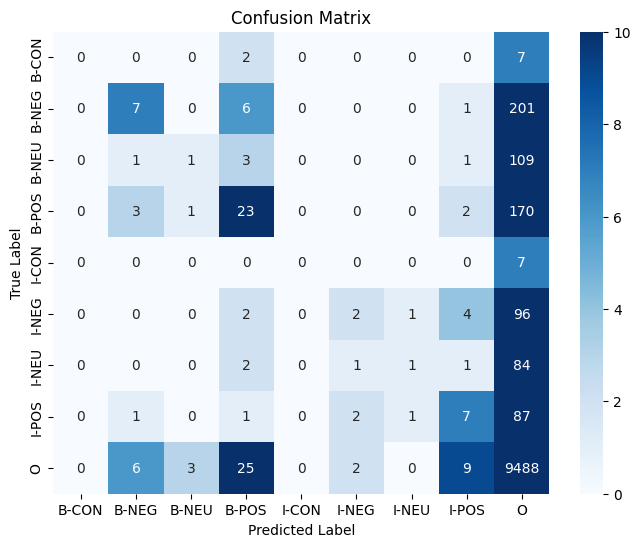

In [472]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_rf, y_pred_rf)

# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_, vmax=10)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# CRF model

In [ ]:
# Create and train CRF model
crf_model = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100)
try:
  crf_model.fit(X_train, y_train)
except AttributeError:
  pass

In [ ]:
# def post_process_predictions(predictions):
#   for i in range(1, len(predictions)):
#       if predictions[i] == 'I' and predictions[i - 1] == 'O':
#           predictions[i] = 'O'  # Change 'I' to 'O' if not preceded by 'B'
#   return predictions

# Model evaluation

## Sample visualization

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import random
from highlight_text import HighlightText, ax_text, fig_text

def vizualize_samples (sentences, pred_tags, tags = None):

  fig, ax = plt.subplots(figsize=(30,10))
  font = {'family' : 'arial',
          'size'   : 16}
  matplotlib.rc('font', **font)
  final_text = []
  color = []
  pos_element = {"bbox": {"edgecolor": "Green", "facecolor": "#99FF00", "linewidth": 1.5, "pad": 1}} 
  neu_element = {"bbox": {"edgecolor": "Orange", "facecolor": "Yellow", "linewidth": 1.5, "pad": 1.5}} 
  neg_element = {"bbox": {"edgecolor": "Red", "facecolor": "#FF99CC", "linewidth": 1.5, "pad": 1}}
  
  color_map = {'POS': pos_element, 'NEU': neu_element, 'NEG':neg_element}

  for s in range(0, len(sentences)):
    final_text.append('(P) ')
    chunk = []
    next_tag = ''
    
    for w in range(0, len(sentences[s])):
      # print(w)
      word = sentences[s][w]
      tag = pred_tags[s][w]
      # print(tag[2:])  
      if w + 1 < len(sentences[s]):
        next_tag = pred_tags[s][w+1]
      else:
        next_tag = 'O'
      
      # print(word, tag, next_tag)

      if tag == 'O':
        final_text.append(word)
      elif (tag in ['I-POS','I-NEG', 'I-NEU','B-POS','B-NEG', 'B-NEU']):
        chunk.append(word)

      if (next_tag in ['B-POS','B-NEG', 'B-NEU', 'O']) & (len(chunk) > 0):
        final_text.append(f'  <{" ".join(chunk)}>  ')
        color.append(color_map[tag[2:]])
        chunk = []

    if tags is not None:
      final_text.append('\n')
      final_text.append('(A) ')
      for w in range(0, len(sentences[s])):
        # print(w)
        word = sentences[s][w]
        tag = tags[s][w]
        if w + 1 < len(sentences[s]):
          next_tag = tags[s][w+1]
        else:
          next_tag = 'O'
          
        if tag == 'O':
          final_text.append(word)
        elif (tag in ['I-POS','I-NEG', 'I-NEU','B-POS','B-NEG', 'B-NEU']):
          chunk.append(word)

        if (next_tag in ['B-POS','B-NEG', 'B-NEU', 'O']) & (len(chunk) > 0):
          final_text.append(f'  <{" ".join(chunk)}>  ')
          color.append(pos_element)
          chunk = []
  


    

    # if tags is not None:
    #   final_text.append('\n')
    #   final_text.append('(A) ')
    #   for w in range(0, len(sentences[s])):
    #     word = sentences[s][w]
    #     tag = tags[s][w]

    #     if tag !='O':
    #       final_text.append('<{}>'.format(word))
    #       if tag in ['I-POS','I-NEG', 'I-NEU']:
    #         # color.append(color[-1])
    #         color.append(pos_element)
    #       else:
    #         color.append ({'color':random.choice(['blue','green','red','magenta'])})
    #     else:
    #       final_text.append(word)
    
    final_text.append('\n---------------\n')


    HighlightText(x=0, y=1,
                s=' '.join(final_text),
                highlight_textprops=color,
                ax=ax)
                
    plt.axis('off')

In [ ]:
samples = 10
integer = 285 #random.randint(0,500)
tags = y_val[integer:integer+samples].array
pred_tags = crf_model.predict(X_val[integer:integer+samples])
sentences = [[x['word.lower()'] for x in sentence] for sentence in X_val[integer:integer+samples]]

print(integer)
vizualize_samples(sentences, pred_tags, tags)


In [ ]:
i = 0
nth = integer + i
print(nth)
print(df_val.iloc[nth]['text'])

print(df_val.iloc[nth]['aspects'])

print(df_val.iloc[nth]['pairs'])

print(pred_tags[i])
print(tags[i])


In [ ]:
# Test the model with new data
sample = pd.Series(['I was pleasantly surprised by the quality of this laptop for the money. '
            ,'I am not super techy so it may be difficult for me to comment on the technical specifications of the laptop, but I was pleasantly surprised with the quality of the product especially at this price point.'])
sample_text_token = [word_tokenize(sentence) for sentence in sample]
X_sample = [sent2features(sentence, 5) for sentence in sample_text_token]

predicted_labels = crf_model.predict(X_sample)

vizualize_samples(sample_text_token, predicted_labels)


In [ ]:
import numpy as np
from sklearn.metrics import classification_report


tags = y_train
pred_tags = crf_model.predict(X_train)


# Create a mapping of labels to indices
labels = {"B-POS": 0, "I-POS": 1, "B-NEU": 2, "I-NEU": 3, "B-NEG": 4, "I-NEG": 5, "O":6}

# Convert the sequences of tags into a 1-dimensional array
predictions = np.array([labels[x] for x in sum([tag for tag in pred_tags],[])])
truths = np.array([labels[x] for x in sum([tag for tag in tags],[])])

# Print out the classification report
print(classification_report(
    truths, predictions,
    target_names= ["B-POS", "I-POS", "B-NEU", "I-NEU", "B-NEG", "I-NEG", "O"])
    )

In [ ]:

tags = y_val
pred_tags = crf_model.predict(X_val)



# Convert the sequences of tags into a 1-dimensional array
predictions = np.array([labels[x] for x in sum([tag for tag in pred_tags],[])])
truths = np.array([labels[x] for x in sum([tag for tag in tags],[])])

# Print out the classification report
print(classification_report(
    truths, predictions,
    target_names=["B-POS", "I-POS", "B-NEU", "I-NEU", "B-NEG", "I-NEG", "O"])
    )

# Next steps
- Add more features:
  - head words
  - Google Word2Vec cluster_id
  - Stemming / Lemming
  - word index from beggining & ending of the sentence
- Employ pre-trained word embeddings
- Re-train model using rule-based aspect term extraction on larger dataset